In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import numpy.matlib
import theano.tensor as tt
import warnings

from sklearn import preprocessing
from theano import shared
from scipy.special import expit as logistic
from scipy.special import softmax
from scipy.stats import betabinom
from matplotlib.patches import Ellipse, transforms

In [2]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))
az.style.use('arviz-darkgrid')

In [3]:
RANDOM_SEED = 42
np.random.seed(42)

In [4]:
import sys, IPython, scipy, matplotlib, pandas, seaborn, patsy, platform, theano, sklearn, statsmodels
print("""This notebook was created using:
Python {}
IPython {}
PyMC3 {}
ArviZ {}
NumPy {}
SciPy {}
Pandas {}
Seaborn {}
Patsy {}
Matplotlib {}
Theano {}
Sklearn {}
Statsmodels {}\n""".format(sys.version[:5], 
                             IPython.__version__, 
                             pm.__version__, 
                             az.__version__, 
                             np.__version__, 
                             scipy.__version__, 
                             pandas.__version__, 
                             seaborn.__version__, 
                             patsy.__version__, 
                             matplotlib.__version__, 
                             theano.__version__, 
                             sklearn.__version__, 
                             statsmodels.api.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.9.2
ArviZ 0.9.0
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Seaborn 0.10.0
Patsy 0.5.1
Matplotlib 3.2.1
Theano 1.0.4
Sklearn 0.22.2.post1
Statsmodels 0.11.1



# Chapter 16 Generalized Linear Madness

## 16.1. Geometric people

### 16.1.1. The scientific model

$W = k\pi p^2h^3  = \pi \theta h^3$

### 16.1.2. The statistical model

### Code 16.1

In [9]:
df = pd.read_csv('Data/Howell1.csv', ';')
df

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0
542,71.120,8.051258,0.0,1


In [11]:
# scale observed variables
df['w'] = df['weight'] / df['weight'].mean()
df['h'] = df['height'] / df['height'].mean()
df

,height,weight,age,male,w,h
0,151.765,47.825606,63.0,1,1.343015,1.097650
1,139.700,36.485807,63.0,0,1.024577,1.010389
2,136.525,31.864838,65.0,0,0.894813,0.987425
3,156.845,53.041915,41.0,1,1.489497,1.134391
4,145.415,41.276872,51.0,0,1.159117,1.051723
...,...,...,...,...,...,...
539,145.415,31.127751,17.0,1,0.874114,1.051723
540,162.560,52.163080,31.0,1,1.464818,1.175725
541,156.210,54.062496,21.0,0,1.518157,1.129798
542,71.120,8.051258,0.0,1,0.226092,0.514380


### Code 16.2

In [87]:
# define model: w ~ h
with pm.Model() as m16_1:

    # fixed priors
    p = pm.Beta('p', alpha=2.0, beta=18.0)
    k = pm.Exponential('k', 1.0)
    sigma = pm.Exponential('sigma', 1.0)
    
    # for posterior predictions
    height = pm.Data('height', df['h'].values)
        
    # linear model
    mu = pm.Deterministic('mu', np.log(np.pi*k*p**2*height**3))
    
    # likelihood for weight 
    weight = pm.Lognormal('weight', mu=mu, sd=sigma, observed=df['w'].values)
    
    trace_m16_1 = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=RANDOM_SEED)
    idata_m16_1 = az.from_pymc3(trace_m16_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, k, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.8883157860103997, but should be close to 0.8. Try to increase the number of tuning steps.


In [26]:
# show model summary
varnames = ['~mu']
az.summary(idata_m16_1, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
p,0.30,0.06,0.21,0.39
k,3.75,1.54,1.52,5.73
sigma,0.21,0.01,0.20,0.22


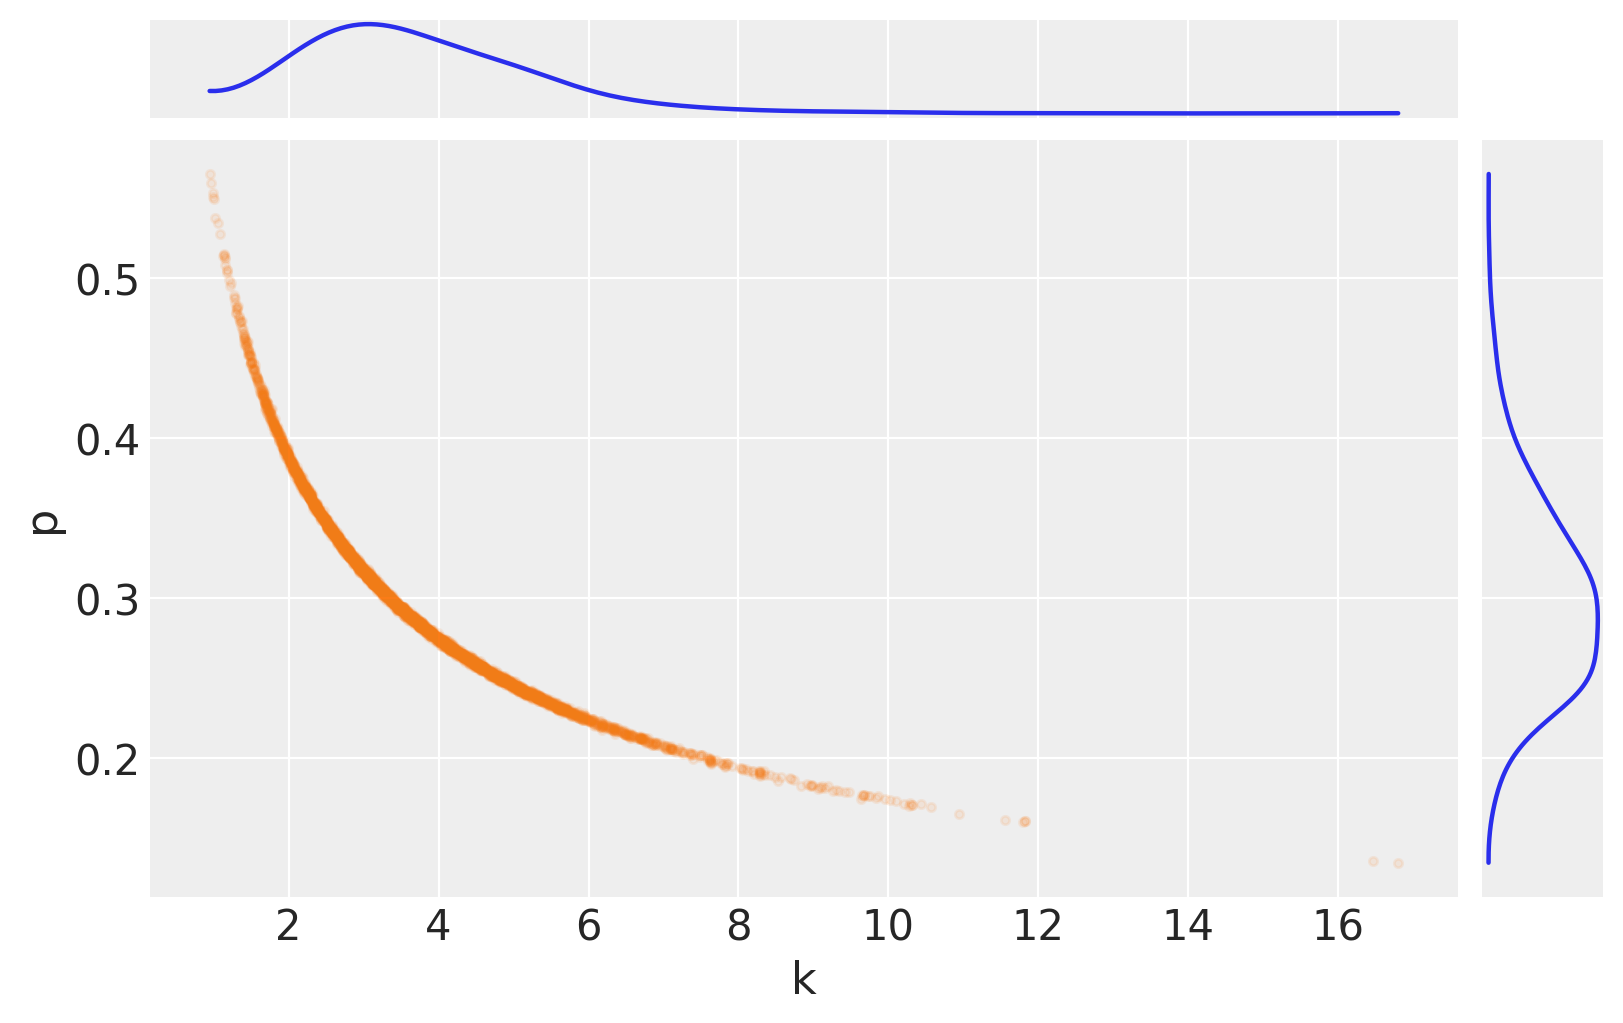

In [58]:
az.plot_pair(
    idata_m16_1,
    group="posterior",
    var_names = ['k','p'],
    coords=None,
    marginals=True,
    figsize=(8,5),
    textsize=15,
    gridsize="auto",
    plot_kwargs=None,
    fill_last=False,
    divergences=True,
    colorbar=False,
    ax=None,
    divergences_kwargs=None,
    scatter_kwargs={'alpha': 0.1, 'color': 'C1'},
    kde_kwargs=None,
    hexbin_kwargs=None,
    backend=None,
    backend_kwargs=None,
    point_estimate=None,
    point_estimate_kwargs=None,
    point_estimate_marker_kwargs=None,
    reference_values=None,
    reference_values_kwargs=None,
    show=None,
);

### Code 16.3

In [126]:
h_seq = np.linspace(0.01, 1.3, 100)

In [127]:
with m16_1:
    pm.set_data(
        {
            'height': h_seq
        }
    )
    post = pm.sample_posterior_predictive(
        trace_m16_1, random_seed=RANDOM_SEED, var_names=['mu', 'weight']
    )

<Figure size 800x500 with 0 Axes>

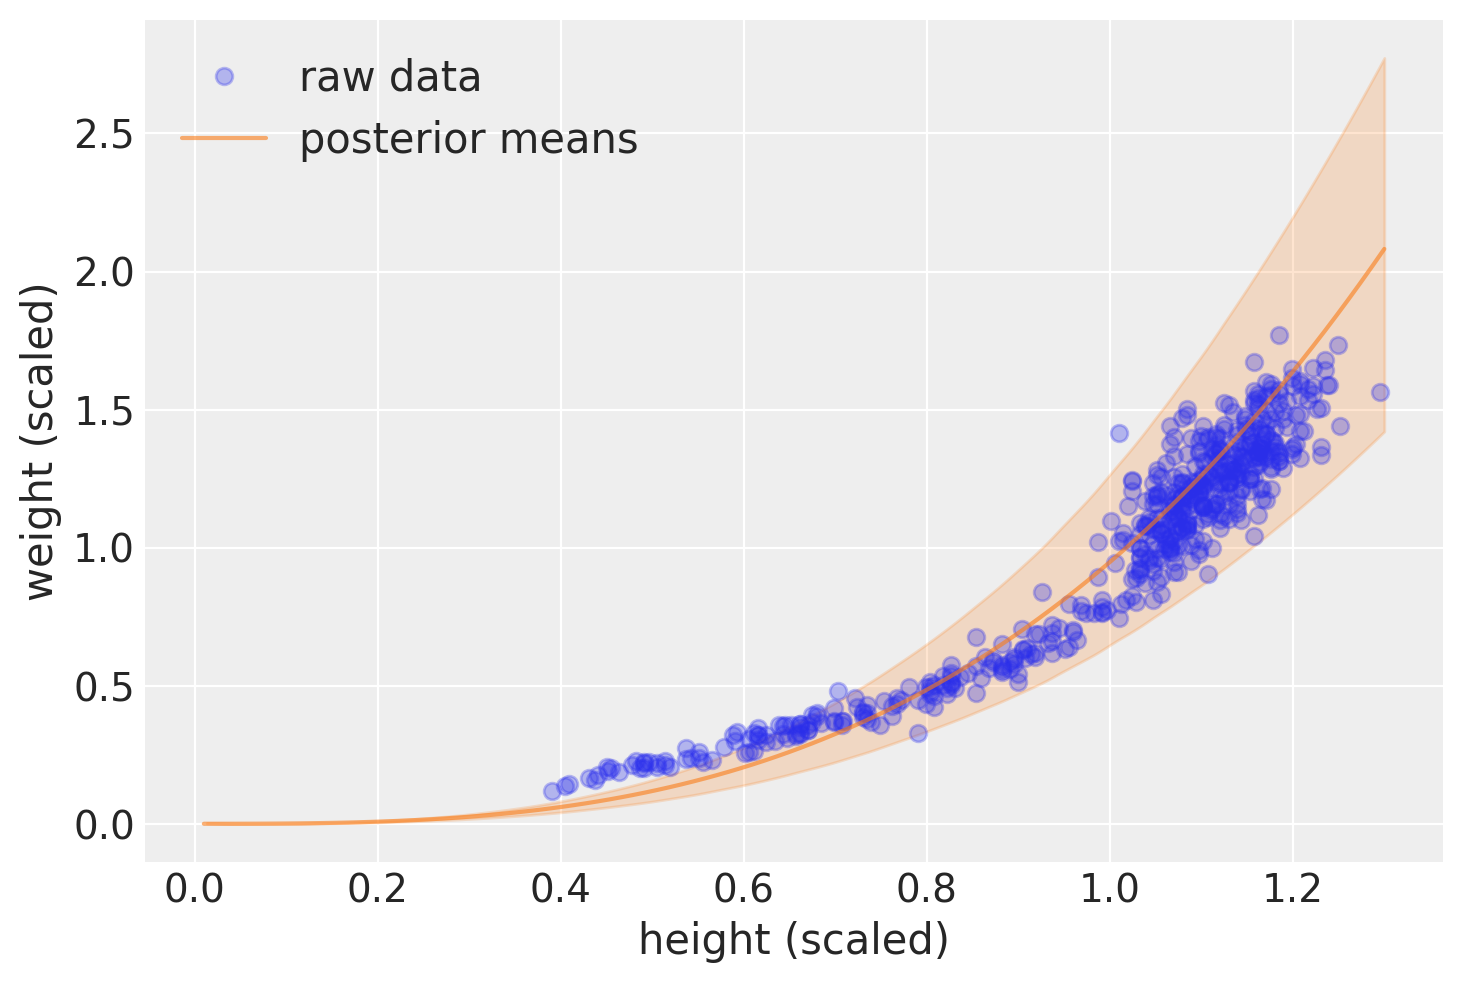

In [142]:
# plot results
fig = plt.figure(figsize=(8, 5))
az.plot_hdi(h_seq, post['weight'],
            color='C1',
            hdi_prob = 0.89,
            fill_kwargs={'alpha': 0.2}
           )
plt.plot(df['h'], df['w'],'C0o', alpha=0.3, label='raw data')
plt.plot(h_seq, np.exp(post['mu'].mean(0)),'-C1', alpha=0.6, label='posterior means')
plt.legend(fontsize=15)
plt.ylabel('weight (scaled)', fontsize=15)
plt.xlabel('height (scaled)', fontsize=15)
plt.show()

### 16.1.3. GLM indisguise

Lots of natural relationships are GLM relationships, on a speicfic scale of mea- surement. At the same time, the GLM approach wants to simply estimate parameters which may be informed by a proper theory, as in this case.

## 16.2. Hidden minds and observed behavior

One of the most basic problem in scientific inference is the so-called **inverse problem**: How to figure out causes from observations. 

### Code 16.4

In [144]:
df = pd.read_csv('Data/Boxes.csv', ';')
df

,y,gender,age,majority_first,culture
0,1,1,6,0,2
1,3,1,8,0,2
2,2,2,8,1,2
3,1,1,6,0,2
4,2,1,5,1,2
...,...,...,...,...,...
624,1,1,12,0,3
625,2,2,13,0,3
626,2,2,12,1,3
627,2,2,13,1,3


In [146]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
y,629.0,2.120827,0.727986,1.0,2.0,2.0,3.0,3.0
gender,629.0,1.505564,0.500367,1.0,1.0,2.0,2.0,2.0
age,629.0,8.030207,2.497906,4.0,6.0,8.0,10.0,14.0
majority_first,629.0,0.484897,0.500170,0.0,0.0,0.0,1.0,1.0
culture,629.0,3.751987,1.960319,1.0,3.0,3.0,5.0,8.0


### Code 16.5

In [176]:
df.groupby(by=['y'])["gender"].count().values/len(df)

array([0.21144674, 0.45627981, 0.33227345])

### 16.2.1. The scientific model

In [191]:
# number of children
N = 30 

# half are random
# sample from 1,2,3 at random for each
y1 = np.random.choice([1, 2, 3], size=int(N/2))

# half follow majority
y2 = np.repeat(2, repeats=int(N/2))

# combine and shuffle y1 and y2
y = np.random.permutation(np.concatenate((y1, y2), axis=0))

# count the 2s
(sum(y==2)/N).round(2)

0.63

### 16.2.2. The statistical model

$y_i ∼ Categorical(\theta)$

$\theta_j = \sum_{s=1}^{5}p_sPr(j|s)$

$p ∼ Dirichlet([4, 4, 4, 4, 4])$

### 16.2.3. Coding the statistical model

### 16.2.4. State space models

## 16.3. Ordinary differential nut cracking

### Code 16.9

In [199]:
df = pd.read_csv('Data/Panda_nuts.csv', ';')
df

,chimpanzee,age,sex,hammer,nuts_opened,seconds,help
0,11,3,m,G,0,61.0,N
1,11,3,m,G,0,37.0,N
2,18,4,f,wood,0,20.0,N
3,18,4,f,G,0,14.0,y
4,18,4,f,L,0,13.0,N
...,...,...,...,...,...,...,...
79,10,15,m,G,7,12.0,N
80,10,15,m,G,5,12.5,N
81,6,15,m,G,8,13.0,N
82,6,16,m,G,24,20.0,N


### 16.3.1. Scientific model

$ λ  = φ(1 − exp(−kt))^\theta$

### 16.3.2. Statistical model

### Code 16.10

In [288]:
N = 1000
phi = np.random.lognormal(mean=np.log(1), sigma=0.1, size=N)
k = np.random.lognormal(mean=np.log(2), sigma=0.25, size=N) 
theta = np.random.lognormal(mean=np.log(5), sigma=0.25, size=N) 

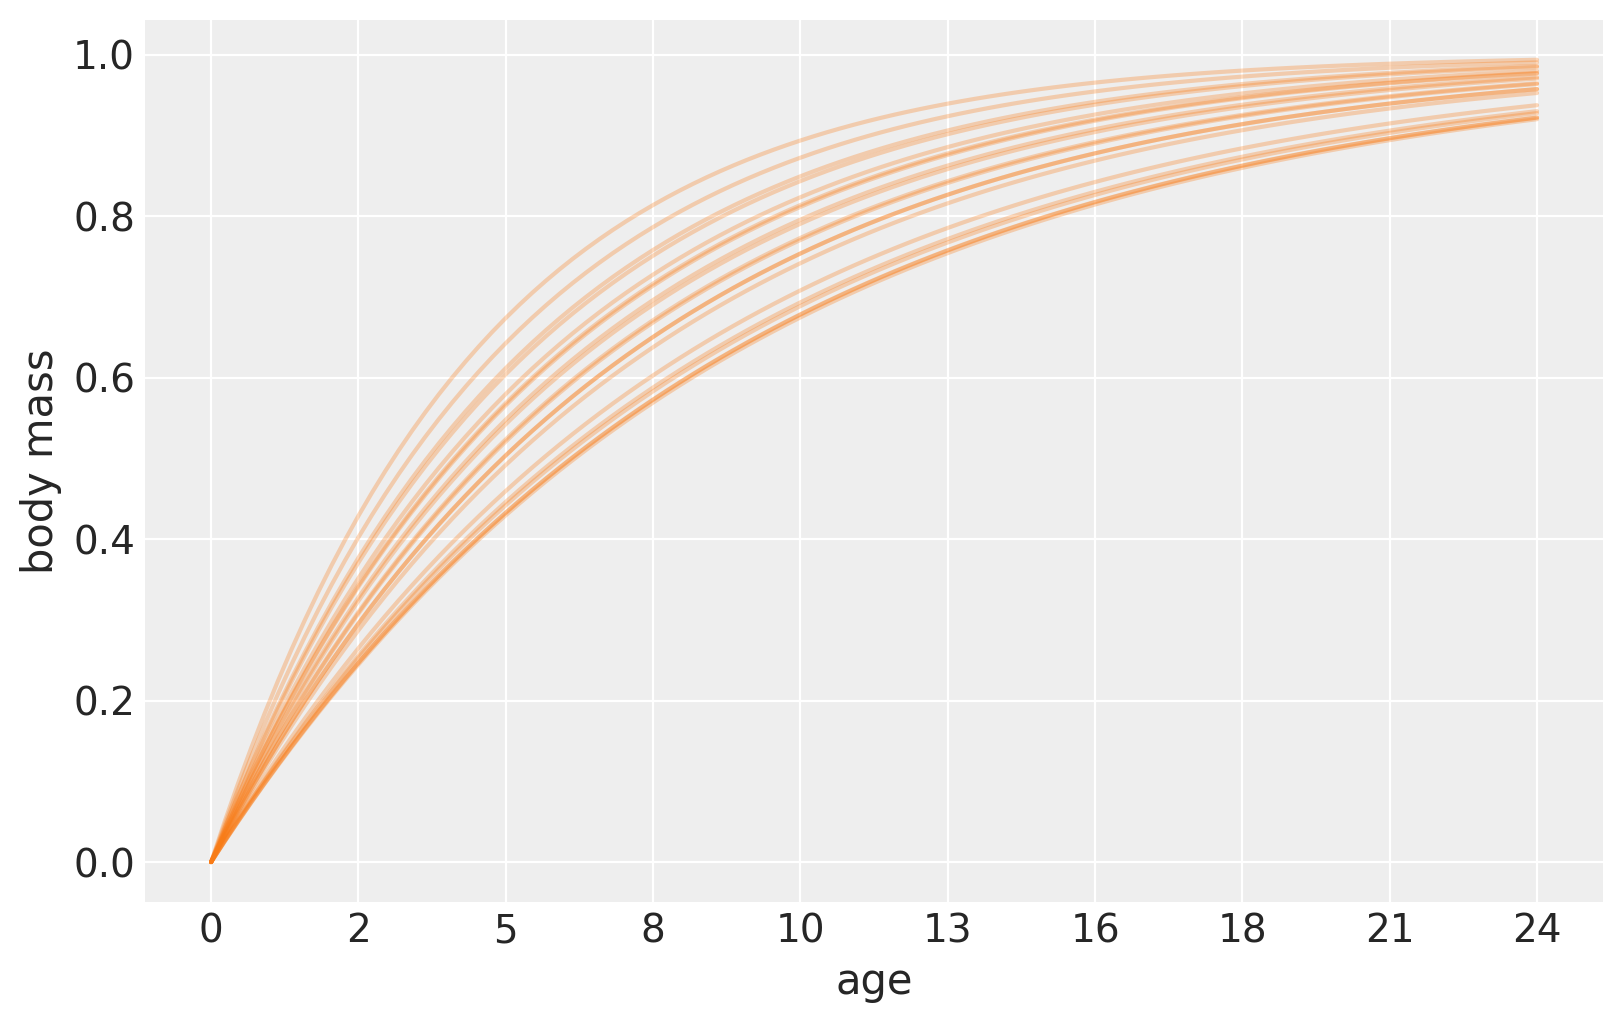

In [289]:
# relative grow curve
t = np.linspace(0, 1.5, 100)
fig = plt.figure(figsize=(8, 5))
for n in range(20):
    plt.plot(t, 1-np.exp(-k[n]*t), alpha=0.3, color = 'C1')
plt.ylabel('body mass', fontsize=15)
plt.xlabel('age', fontsize=15)
at = np.linspace(0, 1.5, 10)
plt.xticks(at, np.int64(at*max(df['age'])))
plt.show()

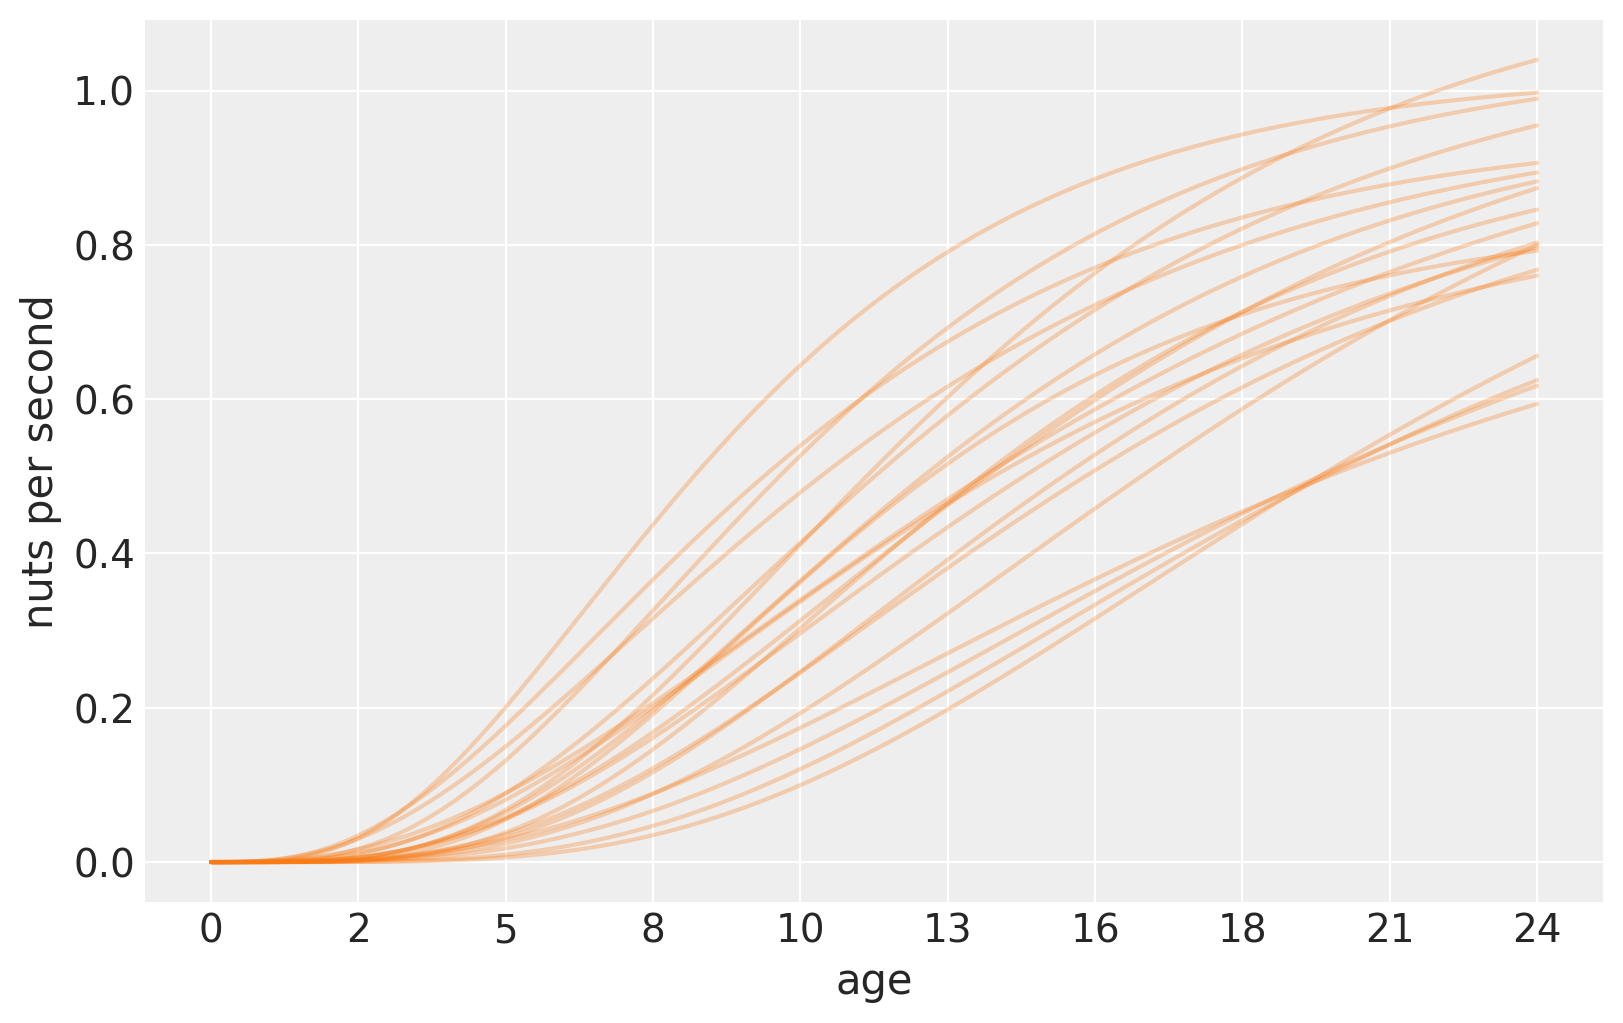

In [290]:
# implied rate of nut opening curve
t = np.linspace(0, 1.5, 100)
fig = plt.figure(figsize=(8, 5))
for n in range(20):
    plt.plot(t, phi[n]*(1-np.exp(-k[n]*t))**theta[n], alpha=0.3, color = 'C1')
plt.ylabel('nuts per second', fontsize=15)
plt.xlabel('age', fontsize=15)
at = np.linspace(0, 1.5, 10)
plt.xticks(at, np.int64(at*max(df['age'])))
plt.show()

### Code 16.11

In [299]:
n = df['nuts_opened'].values
age = df['age'].values / max(df['age'].values)
seconds = df['seconds'].values

In [281]:
# define model: n ~ aged
with pm.Model() as m16_4:

    # fixed priors
    phi = pm.Lognormal('phi', mu=np.log(1), sigma=0.1)
    k = pm.Lognormal('k', mu=np.log(2), sigma=0.25)
    theta = pm.Lognormal('theta', mu=np.log(5), sigma=0.25)
    
    # for posterior predictions
    A = pm.Data('A', age)
       
    # linear model
    lam = pm.Deterministic('lam', seconds*phi*(1-np.exp(-k*A))**theta)
   
    # likelihood  
    n_nuts = pm.Poisson('n_nuts', mu=lam, observed=n)
    
    trace_m16_4 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)
    idata_m16_4 = az.from_pymc3(trace_m16_4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, k, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [249]:
# show model summary
varnames = ['~lam']
az.summary(idata_m16_4, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
phi,0.87,0.04,0.80,0.93
k,5.96,0.59,5.01,6.86
theta,9.82,2.12,6.50,12.80


### Code 16.12

In [292]:
with m16_4:
    pm.set_data(
        {
            'A': np.linspace(0, 1.5, 100)
        }
    )
    post = pm.sample_posterior_predictive(
        trace_m16_4, random_seed=RANDOM_SEED, var_names=['phi', 'k', 'theta']
    )

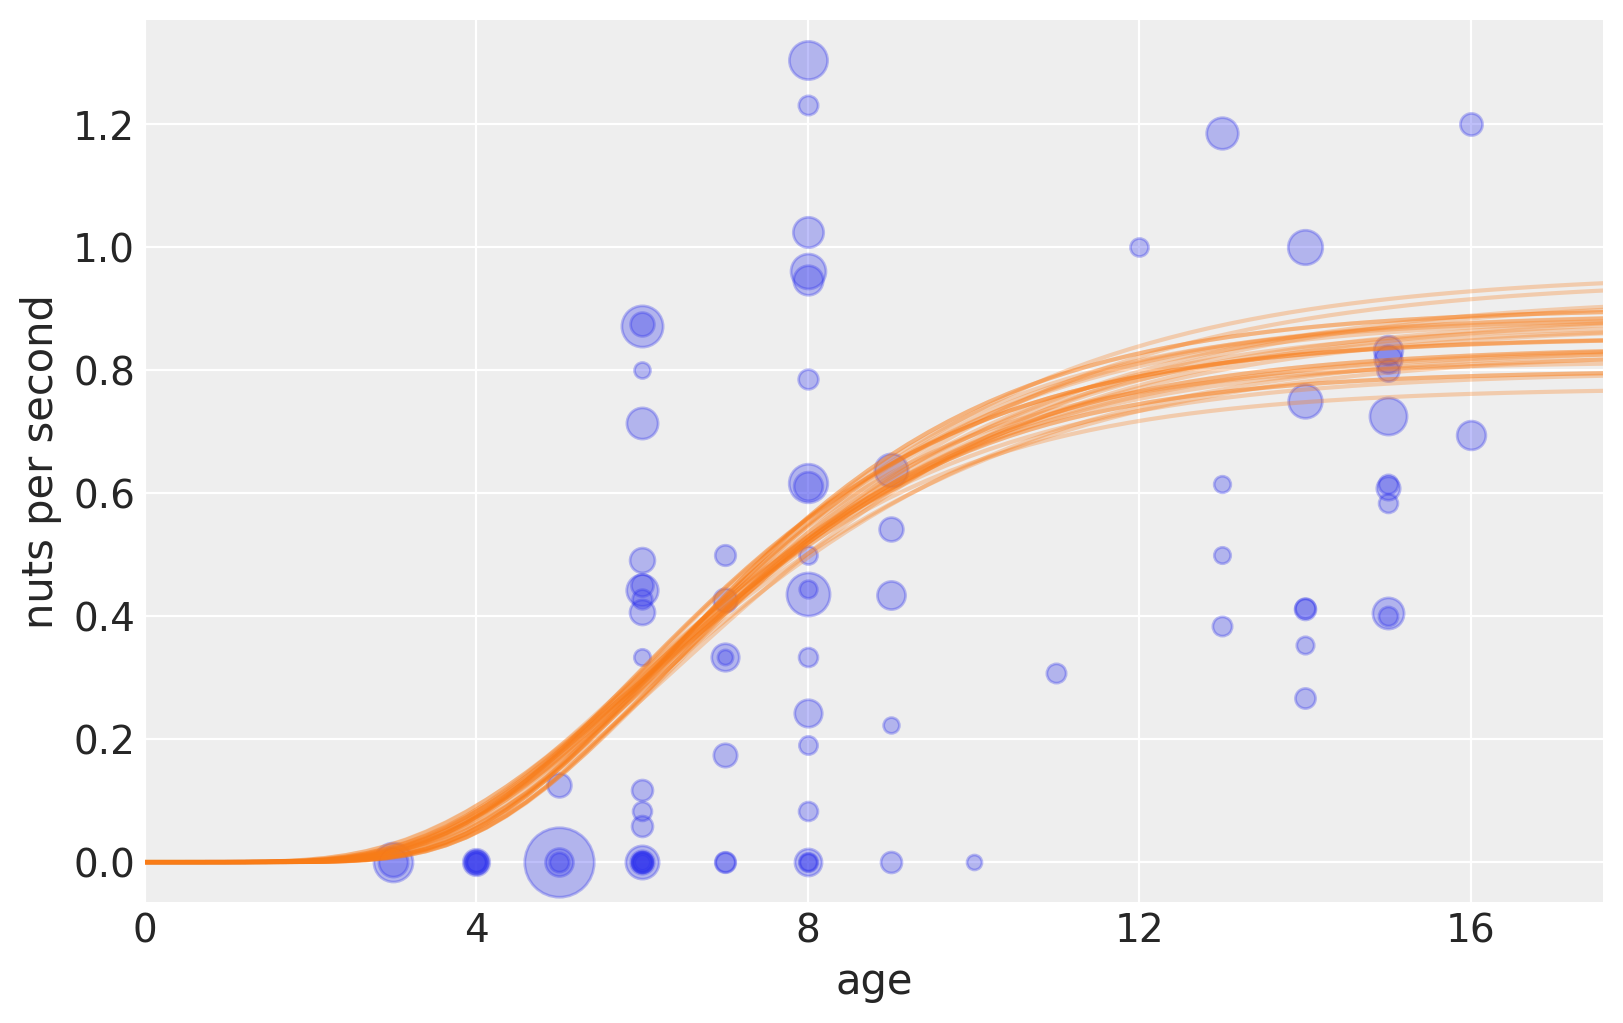

In [303]:
fig = plt.figure(figsize=(8, 5))
# raw data
pts = n/seconds
for i in range (len(df)):
    plt.plot(age[i], pts[i], 
             alpha=0.3, 
             color = 'C0', 
             marker='o',
             markersize = seconds[i]/seconds.max()*20+5)
# 30 posterior curves
for i in range(30):
    plt.plot(t, post['phi'][i]*(1-np.exp(-post['k'][i]*t))**post['theta'][i], alpha=0.3, color = 'C1')
plt.ylabel('nuts per second', fontsize=15)
plt.xlabel('age', fontsize=15)
at = np.linspace(0, 1.5, 7)
plt.xticks(at, np.int64(at*max(df['age'])))
plt.xlim([0, 1.1])
plt.show()

### 16.3.3. Covariates and individual differences

You could extend it to include covariates like sex and individual differences in strength. Yet another improvement to this model might be to use a more realistic model of chim- panzee growth. 

## 16.4. Population dynamics

In this section, we’ll model a time series of hare and lynx populations.

### Code 16.13

In [304]:
df = pd.read_csv('Data/Lynx_Hare.csv', ';')
df

,Year,Lynx,Hare
0,1900,4.0,30.0
1,1901,6.1,47.2
2,1902,9.8,70.2
3,1903,35.2,77.4
4,1904,59.4,36.3
5,1905,41.7,20.6
6,1906,19.0,18.1
7,1907,13.0,21.4
8,1908,8.3,22.0
9,1909,9.1,25.4


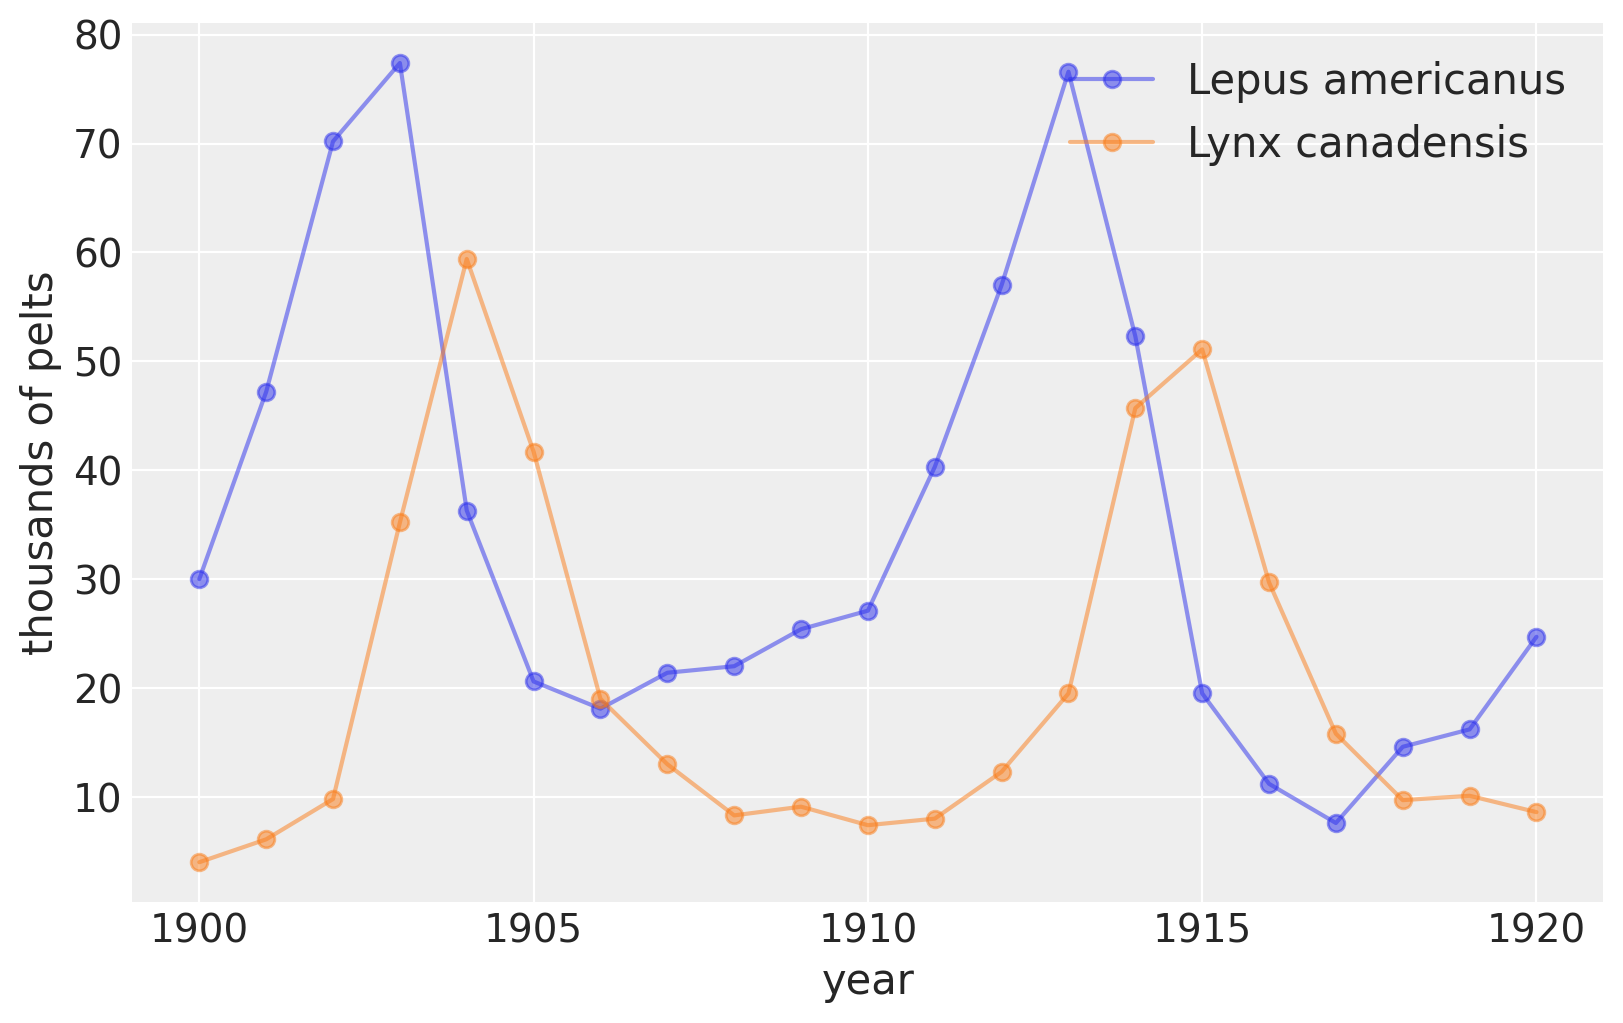

In [315]:
fig = plt.figure(figsize=(8, 5))
plt.plot(df['Year'], df['Hare'], alpha=0.5, color = 'C0', marker = 'o', label='Lepus americanus')
plt.plot(df['Year'], df['Lynx'], alpha=0.5, color = 'C1', marker = 'o', label='Lynx canadensis')
plt.ylabel('thousands of pelts', fontsize=15)
plt.xlabel('year', fontsize=15)
at = np.linspace(1900, 1920, 5)
plt.xticks(at, np.int64(at))
plt.legend(fontsize=15)
plt.show()

A common geocentric way to model a time series like this would be to use something called an **autoregressive model**. 

In the process, you’ll see how to fit systems of **ordinary differential equations (ODEs)** to data.

### 16.4.1. The scientific model

This particular model is a famous one,the **Lotka-Volterra** model.

$\frac{dH}{dt} = H_t(b_H-L_tm_H) $

$\frac{dL}{dt} = L_t(H_tb_L-m_L) $

### Code 16.14

In [354]:
def sim_lynx_hare(n_steps, init, theta, dt=0.02):
    
    L = np.zeros(n_steps)
    H = np.zeros(n_steps)
    
    L[0] = init[0]
    H[0] = init[1]
    
    for t in range(1, n_steps):
        H[t] = H[t-1] + dt*H[t-1]*(theta[0] - theta[1]*L[t-1])
        L[t] = L[t-1] + dt*L[t-1]*(theta[2]*H[t-1] - theta[3])
    
    return L,H

### Code 16.15

In [355]:
n_steps = 1000
theta = [0.5, 0.05, 0.025, 0.5]
init = [df.loc[0].Lynx, df.loc[0].Hare]

In [356]:
L, H = sim_lynx_hare(n_steps, init, theta)

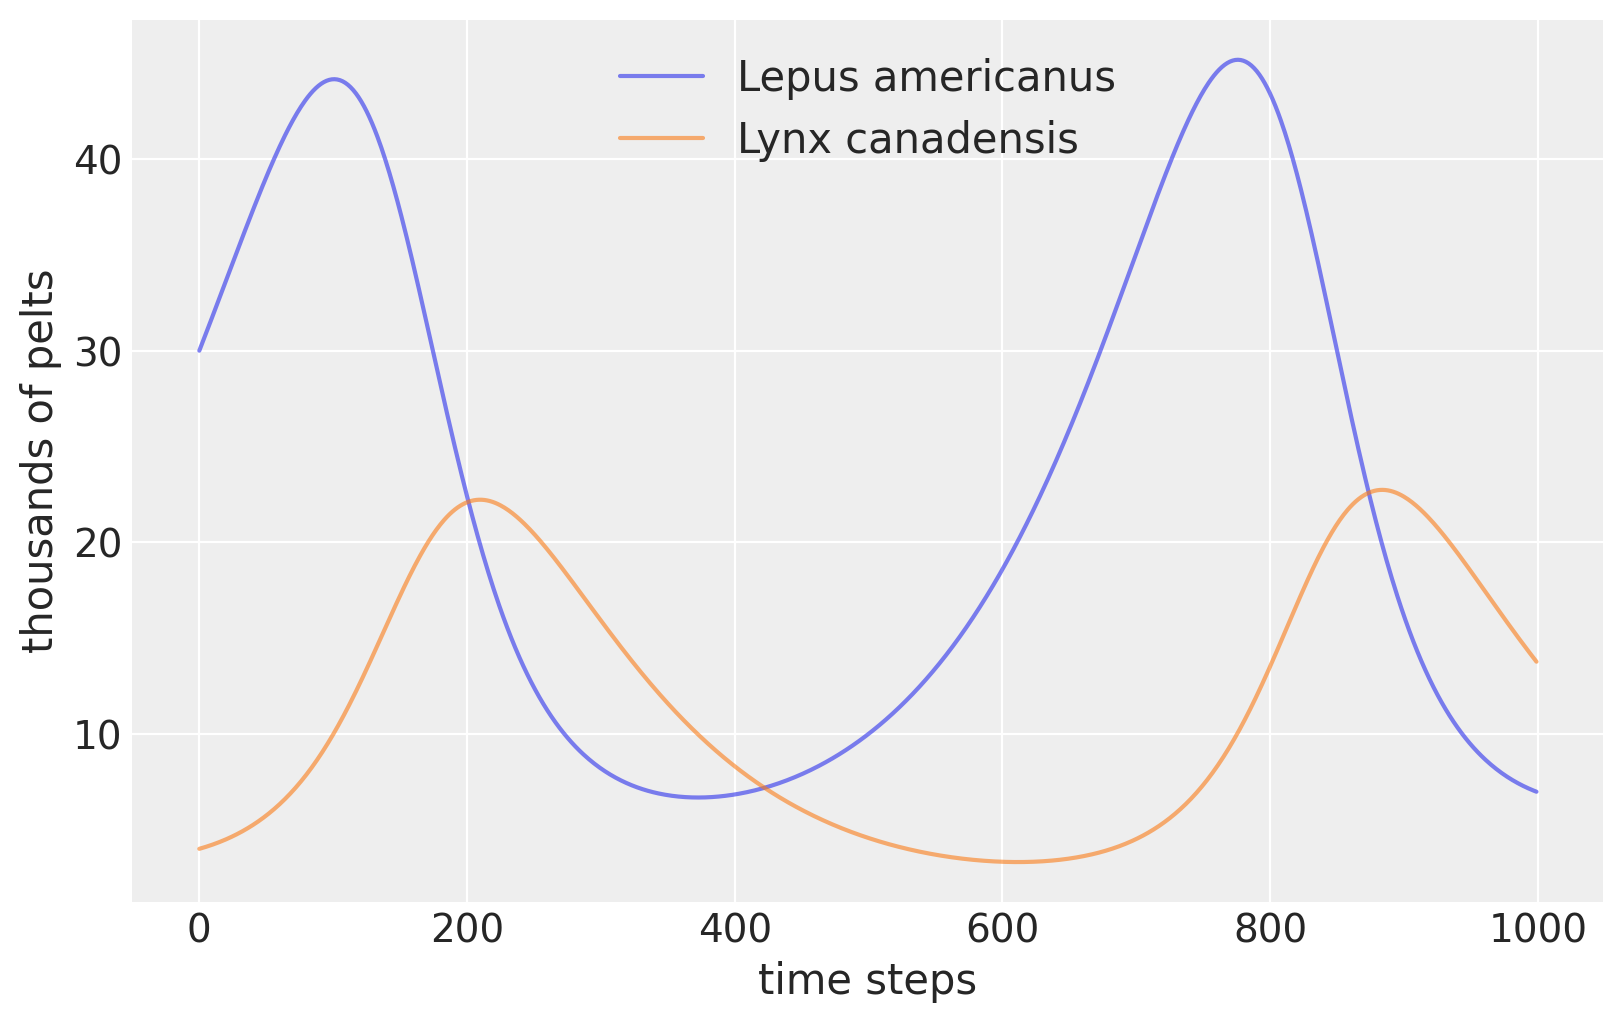

In [359]:
fig = plt.figure(figsize=(8, 5))
plt.plot(range(n_steps), H, alpha=0.6, color = 'C0', label='Lepus americanus')
plt.plot(range(n_steps), L, alpha=0.6, color = 'C1', label='Lynx canadensis')
plt.ylabel('thousands of pelts', fontsize=15)
plt.xlabel('time steps', fontsize=15)
plt.legend(fontsize=15)
plt.show()

### 16.4.2. The statistical model

### Code 16.16

In [363]:
N = 10000
Ht = 10000
p = stats.beta.rvs(a=2, b=18, size=N)
h = np.random.binomial(n=N, p=p, size=Ht)
h = (h/1000).round(2)

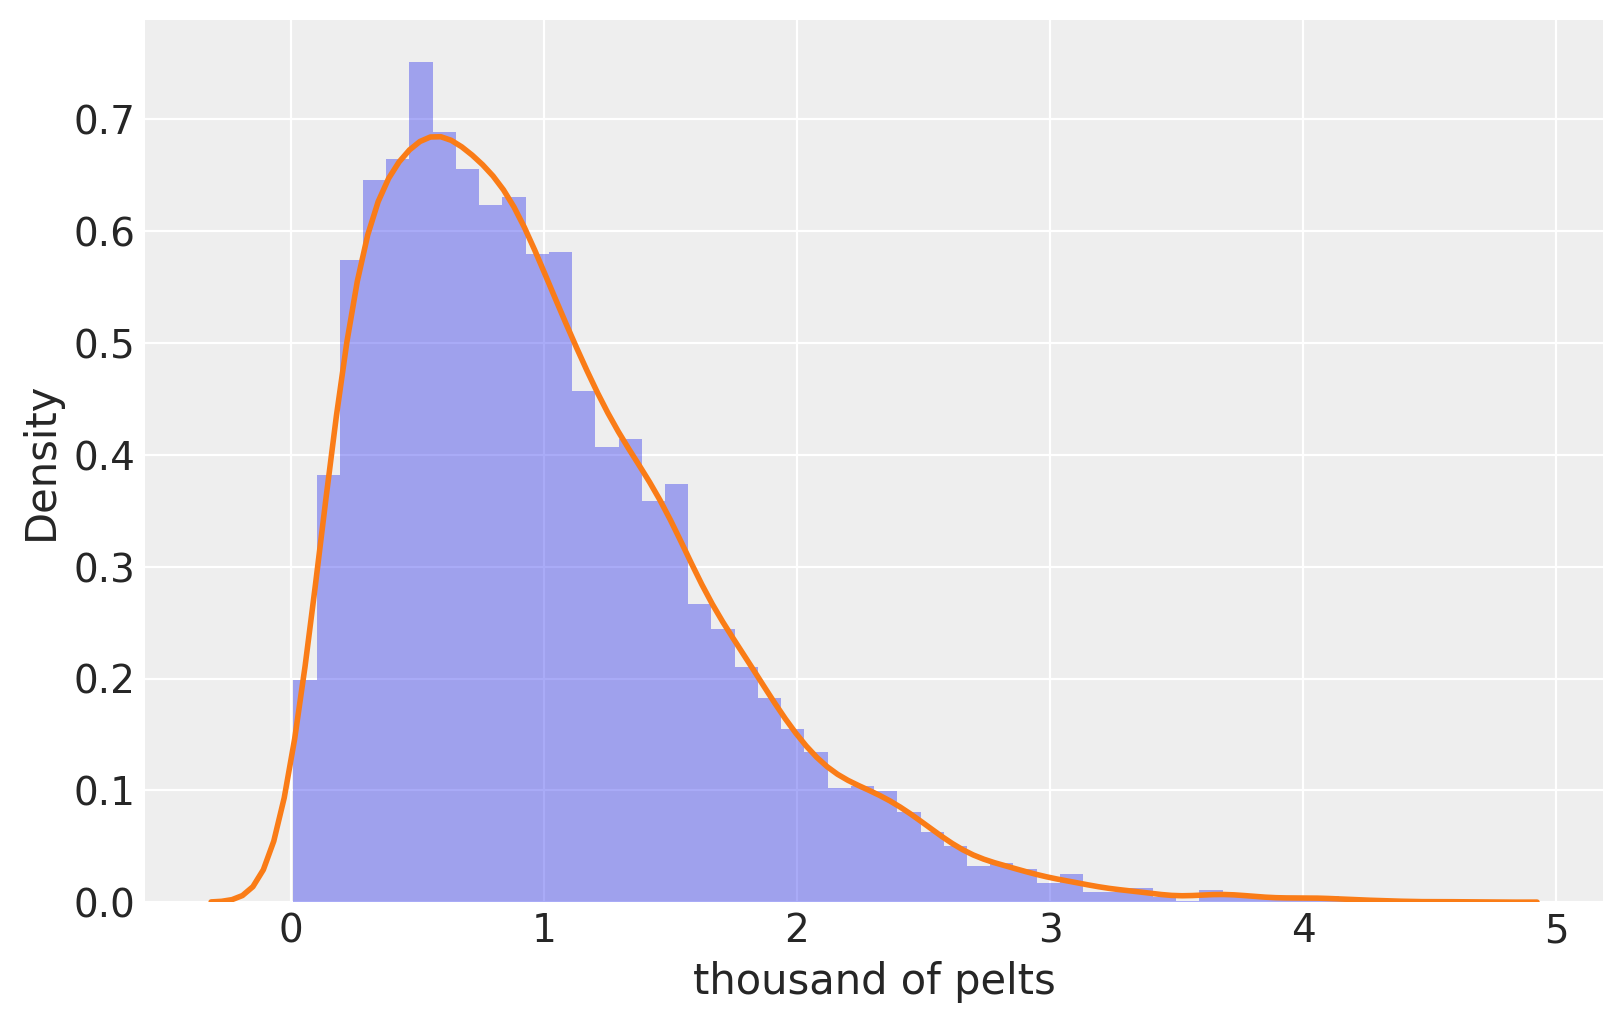

In [368]:
fig = plt.figure(figsize=(8, 5))
sns.distplot(h, 
             hist = True, 
             kde = True, 
             kde_kws = {'linewidth': 2, 'color': 'C1'})
plt.ylabel('Density', fontsize=15)
plt.xlabel('thousand of pelts', fontsize=15)
plt.show()